# Gradient Descent Kimura 2-Parameter Model

Nucleotide substitution model with same probabilities for all transitions, with $\mathcal{S}$ = $\{$A, G, C, T$\}$ and parameter inference for the phylogenetic trees with backwards filtering following https://arxiv.org/abs/2203.04155.

The gradient descent algorithm is incomplete at the moment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.executable)

import hyperiax
import jax
from jax import numpy as jnp
from jax.random import PRNGKey, split
from hyperiax.tree import HypTree, TreeNode
from hyperiax.tree.childrenlist import ChildList
from hyperiax.execution import LevelwiseTreeExecutor
from hyperiax.models import UpLambda
from hyperiax.models.functional import product_fuse_children
from hyperiax.mcmc import Parameter, ParameterStore, UniformParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

import math
import numpy as np
from Bio import Phylo
from io import StringIO
from functools import reduce
import matplotlib.pyplot as plt

from autograd import grad

# create tree and initialize with noise
from hyperiax.tree import HypTree, TreeNode
from hyperiax.tree.childrenlist import ChildList


/Users/sara/anaconda3/envs/hyperiax/bin/python


In [3]:
key = PRNGKey(42)

Kimura 2-parameters kernel function 

In [4]:
def kimura2_matrix(alpha, beta):
    """
    Generates the Kimura 2-Parameter transition matrix for given alpha and beta values.

    Assume:
     i) transitions (A <-> G and C <-> T) have rate alpha,
     ii) transversions (A <-> C, A <-> T, G <-> C, G <-> T) have rate beta.

    Input:
        alpha: The rate of transitions.
        beta: The rate of transversions.

    Output:
        matrix: Kimura 2-Parameter transition matrix.
    """

    # Conditions
    if alpha < 0 or beta < 0 or (alpha + 2*beta) > 1:
        raise ValueError("Alpha and Beta don't follow conditions")

    # 4x4 Transition matrix
    matrix = np.array([[1 - alpha - 2 * beta, alpha, beta, beta],
                      [alpha, 1 - alpha - 2 * beta, beta, beta],
                      [beta, beta, 1 - alpha - 2 * beta, alpha],
                      [beta, beta, alpha, 1 - alpha - 2 * beta]])

    # Probability Matrix rows check
    if not np.allclose(np.sum(matrix, axis=1), 1):
        raise ValueError("The rows are not equal to 1")

    return matrix

In [5]:
# Update Uniform Parameter Class for updates
class UniformParameter(Parameter):
    def __init__(self, value, min=0., max=1., keep_constant=False) -> None:
        super().__init__(value)
        self.min = min
        self.max = max
        self.keep_constant = keep_constant

    def propose(self, key):
        if self.keep_constant:
            return self

        return UniformParameter(jax.random.uniform(key, minval=self.min, maxval=self.max), self.min, self.max,
                                self.keep_constant)

    def update(self, value, accepted):
        if accepted:
            self.value = value

    def log_prior(self):
        return 0.

# Create Tree
First, we initialize the tree with for each node the type, value, and log_sum (norm).

In [6]:
# create tree and initialize with noise
from hyperiax.tree import HypTree, TreeNode
from hyperiax.tree.childrenlist import ChildList

# Initial Newick Tree
newick_string = "(((A,C), (A,T)), ((C, T), (T, G)));"
# newick = Phylo.read(StringIO(newick_string), "newick")

tree_newick = hyperiax.tree.builders.tree_from_newick(newick_string)
# tree_newick = hyperiax.tree.builders.symmetric_tree(h=5, degree=2)

# Prior Data
prior = TreeNode(); prior.name = "prior"
# Root Data
x0 = tree_newick.root; x0.name = "x0"
x0.parent = prior; prior.children = ChildList([x0])
x0.children = tree_newick.root.children

tree = HypTree(prior)
print('Tree:', tree)
tree.plot_tree_text()

# set types to select the right transitions
# types
troot = 0; tinner_node = 1; tleaf_node = 2

for i in tree.iter_bfs():
    i['type'] = tinner_node
    i['log_sum'] = 0

for i in tree.iter_leaves():
    i['type'] = tleaf_node

tree.root['type'] = troot
x0['type'] = troot
  
# number of states
R = 4

# root value
tree.root['value'] = jnp.zeros(R)

# observations, if none then random observations 
nucleotides = ['A', 'G', 'C', 'T']
for i in tree.iter_leaves():
    if i.name in nucleotides:
        i['value'] = jnp.eye(R)[nucleotides.index(i.name)]
    else:
        i['value'] = jnp.eye(R)[np.random.choice(4)]
        i.name = nucleotides[jnp.argmax(i['value'])]

# Number hidden states
for i, node in enumerate(tree.iter_bfs(), start=-1):
    node.name = f'x_{i}' if node.name is None else f'{node.name}'

# root, initial state prior
pi1 = 0.9; pi2 = 0.08; pi3 = 0.01; pi4 = 0.01
km10 = lambda params: jnp.diag([pi1, pi2, pi3, pi4])

# inner node
kst = lambda params: kimura2_matrix(params['alpha'], params['beta'])

# leaves
lambdi = lambda params: jnp.eye(R)

# using jax.lax.cond instead of python ifs
def transition(value, type, params):
    return jax.lax.cond(type == tinner_node,
                        lambda: jnp.dot(kst(params), value),
                        lambda: jax.lax.cond(type == tleaf_node,
                                             lambda: jnp.dot(kst(params), jnp.dot(lambdi(params), value)),
                                             lambda: jnp.array([pi1, pi2, pi3, pi4])
                                            )
                       )

Tree: HypTree with 5 levels and 16 nodes
     prior
       │
       x0
   ┌───┴───┐
   *       *   
 ┌─┴─┐   ┌─┴─┐ 
 *   *   *   * 
┌┴┐ ┌┴┐ ┌┴┐ ┌┴┐
A C A T C T T G


Parameters for the kimura transition kernel.

In [7]:
# parameters, alpha with uniform prior
params = ParameterStore({
    'alpha': UniformParameter(value=.05),  # alpha parameter for kst (Kimura)
    'beta': UniformParameter(value=.15),   # beta parameter for kst (Kimura)
})

true_params = ParameterStore({
    'alpha': UniformParameter(value=.05),  # alpha parameter for kst (Kimura)
    'beta': UniformParameter(value=.15),   # beta parameter for kst (Kimura)
})

We now define the backwards filter through the up and fuse functions. In this case, the up operation is first a matrix multiplication and then a dot product of the children.

In [8]:
# backwards filter. The operation is vmap'ed over the batch dimension (leading dimension)
# @jax.jit
def up(value, type, params, **args):
    return jax.vmap(lambda value, type: {'value': transition(value, type, params)})(value, type)

def norm_product_fuse(**kwargs):
    value = reduce(lambda x, y: x * y, kwargs['child_value']).reshape(-1)
    new_value = value / jnp.linalg.norm(value)
    log_sum = math.log(jnp.linalg.norm(value))
    return {'value': new_value, 'log_sum': log_sum}


We create the model and executor for the backwards filter (up) with the normalized product of the values after joining them.

In [9]:
# create model and executor
save_tree = tree.copy()
upmodel = UpLambda(up_fn=up, fuse_fn=norm_product_fuse)
upexec = LevelwiseTreeExecutor(upmodel)

In [10]:
# execture backwards filter
utree = upexec.up(tree, params.values())

# It also normalizes the prior right now so
utree.root.data['log_sum'] = 0
utree.root.data['value'] = jnp.array([pi1, pi2, pi3, pi4])

# print results
total_log_sum = 0
for node in utree.iter_bfs():
    print(node.name)
    print(node.data)
    total_log_sum += node.data['log_sum']
    

prior
{'type': 0, 'log_sum': 0, 'value': Array([0.9 , 0.08, 0.01, 0.01], dtype=float32)}
x0
{'type': 0, 'log_sum': -1.0951989004641007, 'value': Array([0.6185585 , 0.32203987, 0.32726595, 0.6376305 ], dtype=float32)}
x_1
{'type': 1, 'log_sum': -1.0093095497920384, 'value': Array([0.90671396, 0.09328599, 0.29083276, 0.29083282], dtype=float32)}
x_2
{'type': 1, 'log_sum': -0.8648523405059749, 'value': Array([0.19973549, 0.6227047 , 0.23106651, 0.7203839 ], dtype=float32)}
x_3
{'type': 1, 'log_sum': -1.9783793771074984, 'value': Array([0.70502394, 0.05423261, 0.70502394, 0.05423261], dtype=float32)}
x_4
{'type': 1, 'log_sum': -1.9783793771074984, 'value': Array([0.70502394, 0.05423261, 0.05423261, 0.70502394], dtype=float32)}
x_5
{'type': 1, 'log_sum': -2.884160509870688, 'value': Array([0.40249225, 0.40249225, 0.5813777 , 0.5813777 ], dtype=float32)}
x_6
{'type': 1, 'log_sum': -1.9783793771074984, 'value': Array([0.05423261, 0.70502394, 0.05423261, 0.70502394], dtype=float32)}
A
{'type':

# Likelihood Computation
We compute the likelihood as the dot product of the prior kernel and the value at the root, plus the norms of the normalized values.

In [11]:
# Compute Log-Likelihood
prior_vec = utree.root.data['value']
h0_vec = utree.root.children[0].data['value']

log_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
print(f"The likelihoog is {log_lik}")

The likelihoog is -12.312714064841247


# Parameters Comparation
Contour plot of log-likelihood results for different combinations of alpha and beta.

In [12]:
alpha_range = np.linspace(0.02, 0.32, 50)
beta_range = np.linspace(0.02, 0.32, 50)
likelihoods = np.zeros((len(alpha_range), len(beta_range)))

for i, new_alpha in enumerate(alpha_range):
    for j, new_beta in enumerate(beta_range):
        # Update alpha
        params['alpha'].update(float(new_alpha), True)
        params['beta'].update(float(new_beta), True)

        # create model and executor
        upmodel = UpLambda(up_fn=up, fuse_fn=norm_product_fuse)
        upexec = LevelwiseTreeExecutor(upmodel)

        # execture backwards filter
        new_tree = upexec.up(tree, params.values())

        # Compute Log-Likelihood
        prior_vec = jnp.array([pi1, pi2, pi3, pi4])
        h0_vec = new_tree.root.children[0].data['value']
        
        new_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
        likelihoods[i, j] = new_lik

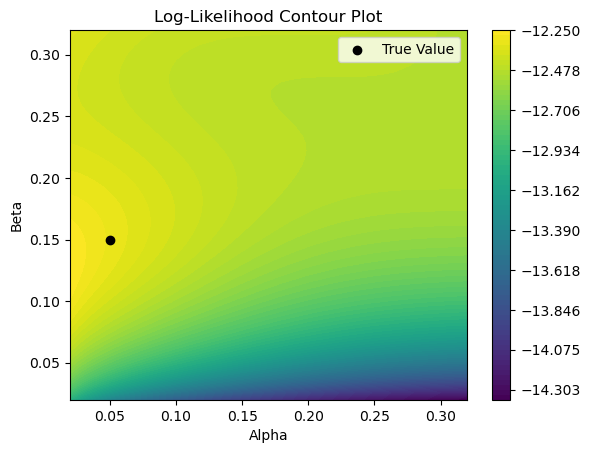

In [13]:
alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)

plt.figure()
levels = np.linspace(np.min(likelihoods), np.max(likelihoods), 75)
cp = plt.contourf(alpha_grid, beta_grid, likelihoods.T, cmap='viridis', levels=levels)
plt.colorbar(cp)

# Plot the true values point
plt.scatter(true_params['alpha'].value, true_params['beta'].value, color='black', label='True Value')
plt.legend()

plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title('Log-Likelihood Contour Plot')
plt.savefig("K2_Contour.png")
plt.show()

# Gradient Descent 

In [14]:
# With Error
import autograd.numpy as anp
from autograd import grad

def init_up(tree):
    for node in tree.iter_bfs():
        if node.children and node.parent:
            node.data['log_sum'] = 0
            node.data['value'] = jnp.zeros(R)
        else:
            node.data = {**node.data, 'value': node['value'], 'log_sum': 0}
    

def log_likelihood(save_tree, params, upexec):
    # new_tree = tree.copy(); init_up(new_tree)
    new_tree = upexec.up(save_tree, params.values())
    # Compute Sum to Add
    total_log_sum = 0
    for node in new_tree.iter_bfs():
        total_log_sum += node.data['log_sum']

    # Compute Log-Likelihood
    prior_vec = new_tree.root.data['value']
    h0_vec = new_tree.root.children[0].data['value']

    log_like = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
    return log_like

# Backward pass
objective = lambda params: log_likelihood(save_tree, params, upexec)
gradients = grad(objective)(params.values())

print("Gradients:")
print(gradients)

# Optimize

TypeError: list indices must be integers or slices, not str